<a href="https://colab.research.google.com/github/Hurri301/Healthcare-Projects/blob/main/EEG_Project_S%26Ihealth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import itertools
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import randint

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
random_seed = 40

In [4]:
#Shuffle the DataFrame samples (rows)
df = df.sample(frac=1).reset_index(drop=True)

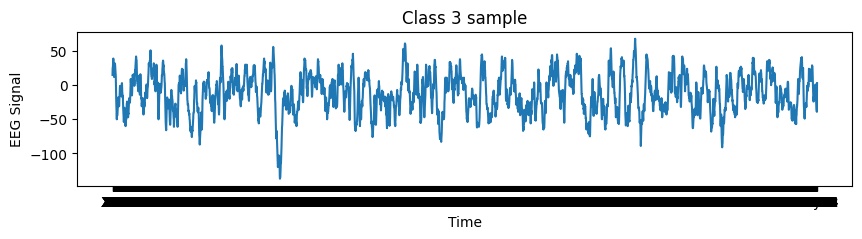

In [5]:
#plotting patient 3
one_sample_3 = df[df['y'] == 3].iloc[0]
plt.figure( figsize = (10, 2))
plt.plot(one_sample_3, label = "class_3_sample")

plt.xlabel('Time')
plt.ylabel('EEG Signal')
plt.title('Class 3 sample')

plt.show()

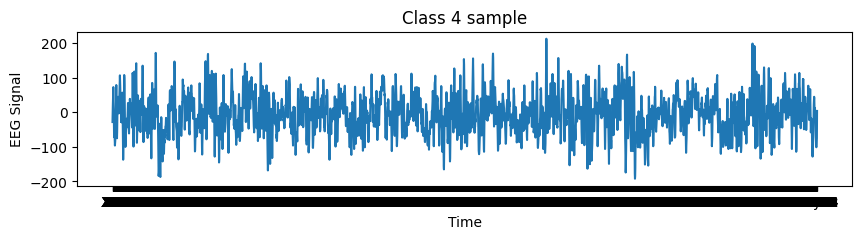

In [6]:
#plotting patient 4
one_sample_4 = df[df['y'] == 4].iloc[0]
plt.figure( figsize = (10, 2))
plt.plot(one_sample_4, label = "class_4_sample")

plt.xlabel('Time')
plt.ylabel('EEG Signal')
plt.title('Class 4 sample')

plt.show()

In [7]:
def outlier_detection( df_o, outlier_threshold ):

  target_classes = [3, 4]
  dict_without_outliers = {}
  dataset_count = 0

  for i in target_classes:
    df_ = df_o[df_o['y'] == i].drop('y', axis = 1)
    # print(df_.head(2))

    df_mean =  df_.mean()
    df_std  =  df_.std()

    df_upper_bound = df_mean + df_std
    df_lower_bound = df_mean - df_std

    # plotting the graphs
    plt.figure( figsize = (12, 3))
    plt.plot(df_mean, label = "mean")
    plt.plot(df_mean + df_std, label = "mean+std")
    plt.plot(df_mean - df_std, label = "mean-std")

    plt.legend( loc = "upper left" )

    plt.xlabel('Time')
    plt.ylabel('EEG Signal')
    plt.title(f'Class {i} samples')
    plt.show()

    ### check the outliers, True --- not outlier, False --- Outlier
    df_boolean = df_.apply( lambda x: ( x >= df_lower_bound ) & ( x <= df_upper_bound ), axis = 1 )

    ### Apply boolean indexing and replace the outliers with NaN values
    result_df = df_.mask( df_boolean == False )

    ### drop values with threshold
    threshold_ = len(result_df.columns) * ( outlier_threshold / 100)  #  must have at least x non-missing values
    df_filtered = result_df.dropna(thresh = threshold_)

    ### Fill na values with the median value
    df_final = df_filtered.fillna( df_filtered.median() )

    ### add class column
    df_final['y'] = i

    df_name = 'class_'+str(i)+'_thre_'+str(outlier_threshold)
    dict_without_outliers[ df_name ] = df_final

    print(f'{df_name} --- {df_final.shape}')
    dataset_count += df_final.shape[0]

  # Concatenate DataFrames stored in the dictionary vertically
  df_without_outliers = pd.concat( [_df_ for _df_ in dict_without_outliers.values()], axis=0)
  print(f'shape of data without outlietrs --- {dataset_count}')
  return df_without_outliers

In [8]:
def normalization_func( df_, method ):
  x = df_.drop('y', axis = 1 )
  y = df_['y']
  if method == 'linear_norm': ## 1. Linear Normalization --- (x - x_min) / (x_max - x_min)
    df_linear_norm = ( x - x.min() ) / ( x.max() - x.min() )
    df_linear_norm['y'] = y
    return df_linear_norm
  elif method == 'z_score': ### 2.  Z-score (Standardization) --- (x - x_mean) / x_std
    df_z_score_norm = ( x - x.mean() ) / x.std()
    df_z_score_norm['y'] = y
    return df_z_score_norm

In [9]:
def svm_model(df_1, kernel, data_desc):

  results_list = []

  x = df_1.drop('y', axis = 1)
  y = df_1['y']

  x_train, x_test, y_train, y_test = train_test_split( x, y, test_size = 0.10, random_state = 40 ) #

  # Initialize SVM classifier
  model = svm.SVC(kernel=kernel, C=0.01).fit(x_train, y_train)

  cv_scores = cross_val_score(model, x_train, y_train, cv=2)
  # print('cv accuracy ---', cv_scores.mean(), '\n')

  # Make predictions on the test set
  y_pred = model.predict(x_test)

  # print('Evaluation on Testing dataset *********************** \n')
  # print(f'actual values --- {list(y_test.values)}')
  # print(f'predic values --- {list(y_pred)}')

  # Calculate test accuracy
  accuracy_test = accuracy_score(y_test, y_pred)
  # print(f'Test accuracy -- {accuracy_test}\n')

  # Calculate confusion matrix
  conf_matrix_test = confusion_matrix(y_test, y_pred)
  # print(conf_matrix_test,'\n')

  # Calculate precision (specificity) -- TN / ( TN + FP) --- shows true negative rate
  # how well a model can classify subjects who truly do not have the disease
  specificity = precision_score(y_test.values, y_pred, pos_label=4)
  # print(f'Precision --- {specificity}')

  # Calculate recall (sensitivity) -- TP / ( TP + FN ) --
  sensitivity = recall_score(y_test, y_pred, pos_label = 4 )
  # print(f'recall --- {sensitivity}')

  # Compute the ROC AUC score
  roc_auc = roc_auc_score( y_test, y_pred )
  # print(roc_auc)
  results_list.append(data_desc)
  results_list.append(kernel)
  results_list.append(round(accuracy_test, 2))
  results_list.append( round(specificity, 2))
  results_list.append(round(sensitivity, 2))
  results_list.append(round(roc_auc, 2))

  return results_list

  ### 7 itmes for class 3
  ### 13 items for class 4

In [10]:
################ Run the loop to run over different combination of parameters ################
dataset_desc = [ 'full_data', 'without_outliers'] #
outlier_thresholds = [ 50, 60 ]
norm_methods = [ 'linear_norm', 'z_score' ]
kernels = [ "linear", "poly", "rbf" ]
results_columns = [ 'dataset' , 'kernel' ,'accuracy', 'specificity', 'sensitivity', 'roc_auc_score']

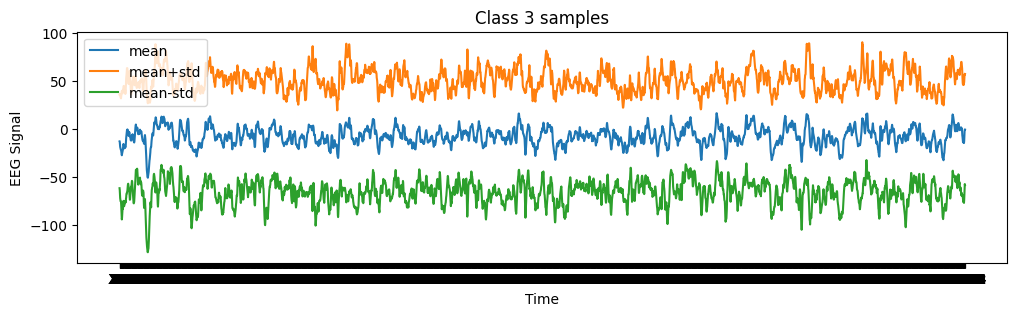

<ipython-input-7-827456d7abeb>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_3_thre_50 --- (78, 4095)


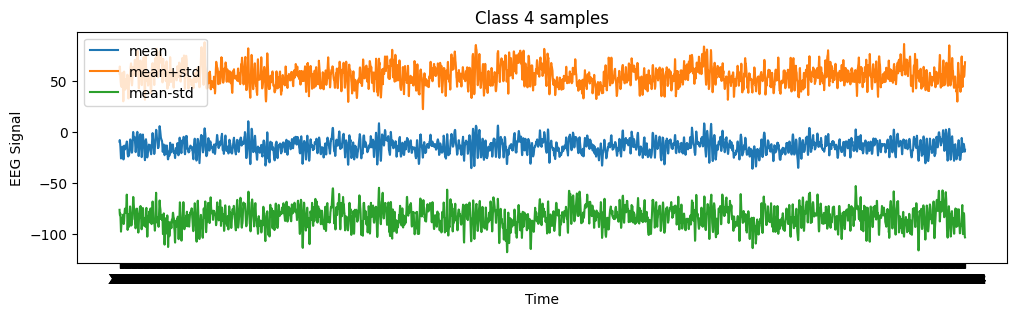

<ipython-input-7-827456d7abeb>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_4_thre_50 --- (77, 4095)
shape of data without outlietrs --- 155


<ipython-input-8-d42a3c9b846b>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_linear_norm['y'] = y
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


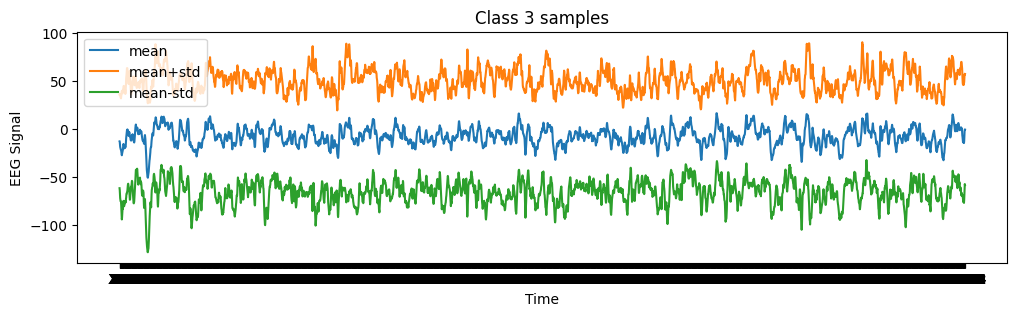

<ipython-input-7-827456d7abeb>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_3_thre_60 --- (68, 4095)


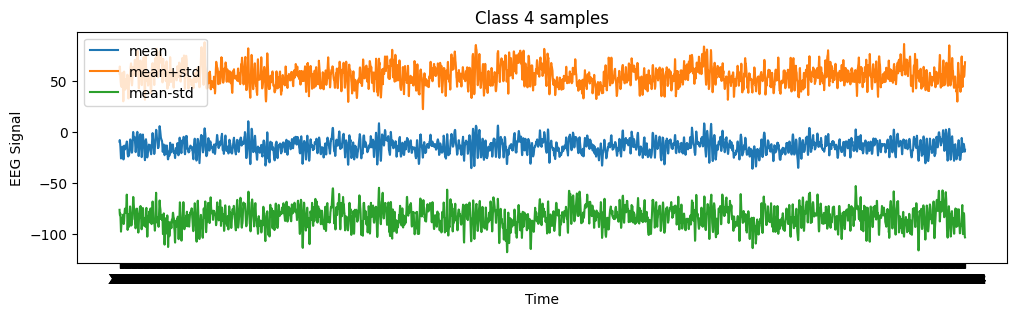

<ipython-input-7-827456d7abeb>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_4_thre_60 --- (60, 4095)
shape of data without outlietrs --- 128


<ipython-input-8-d42a3c9b846b>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_linear_norm['y'] = y
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
######################################################################################
######################################################################################
# PROCESSING WITH ALL HYPERPARAMETERS
results_dict_global = {}
results_list = []

for data in dataset_desc: ## for full data set
  if data == 'full_data':
    ### Normalization
    df_norm = normalization_func(df, norm_methods[0]).round(decimals=3)
    ### Run Model
    for k in kernels:
      results_dict_local = svm_model( df_norm, k, data )
      results_dict_global[data + '#' + k] = results_dict_local

  elif data == 'without_outliers':
    for threshold in outlier_thresholds:
    ### outlier detection and removal
      df_without_outlier = outlier_detection( df, threshold )

      ### Normalization
      df_norm = normalization_func(df_without_outlier, norm_methods[0]).round(decimals=3)
      ### Run Model
      for k in kernels:
        results_dict_local = svm_model( df_norm, k, data + '_' + str(threshold) )
        results_dict_global[ data + '_' + str(threshold)  + '#' + k] = results_dict_local


In [12]:
########### store the results in one dataframe

dict_final = {}
for prefix in sorted(list(set([  key.split('#')[0] for key in results_dict_global.keys() ]))):
  print(prefix)
  # Filter keys based on condition (e.g., keys starting with 'key')
  filtered_keys = [key for key in results_dict_global.keys() if key.startswith(prefix)]
  # Create a list of dictionaries that meet the condition
  filtered_dicts = [ results_dict_global[key] for key in filtered_keys ]
  # # Create DataFrame from the filtered dictionaries
  df_result = pd.DataFrame(filtered_dicts, columns = results_columns)
  # print(df_result, '\n')
  dict_final[prefix] = df_result

full_data
without_outliers_50
without_outliers_60


In [13]:
df_final = pd.concat(dict_final.values())
df_final

,dataset,kernel,accuracy,specificity,sensitivity,roc_auc_score
0,full_data,linear,0.82,0.86,0.75,0.82
1,full_data,poly,0.88,0.88,0.88,0.88
2,full_data,rbf,0.47,0.47,1.00,0.50
0,without_outliers_50,linear,1.00,1.00,1.00,1.00
1,without_outliers_50,poly,1.00,1.00,1.00,1.00
2,without_outliers_50,rbf,0.44,0.00,0.00,0.50
0,without_outliers_60,linear,1.00,1.00,1.00,1.00
1,without_outliers_60,poly,1.00,1.00,1.00,1.00
2,without_outliers_60,rbf,0.69,0.00,0.00,0.50


In [14]:
def get_best_features_random_forest(df_temp):

  x = df_temp.drop('y', axis = 1)
  y = df_temp['y']
  x_train, x_test, y_train, y_test = train_test_split( x, y, test_size = 0.20, random_state = random_seed )

  param_dist = {'n_estimators': randint(50,500),
                'max_depth': randint(1,20)}

  # Create a random forest classifier
  rf = RandomForestClassifier( random_state = random_seed )

  # Use random search to find the best hyperparameters
  rand_search = RandomizedSearchCV(rf,
                                  param_distributions = param_dist,
                                  n_iter=5,
                                  cv=5)

  # Fit the random search object to the data
  rand_search.fit(x_train, y_train)

  # Create a variable for the best model
  best_rf = rand_search.best_estimator_

  return best_rf, x_test,  y_test, x_train, y_train

In [15]:
def best_random_forest_classifier(best_rf, x_test, y_test, data_desc, x_train, y_train):

  results_list = []
  # Generate predictions with the best model
  y_pred = best_rf.predict(x_test)

  # Create the confusion matrix
  # cm = confusion_matrix(y_test, y_pred)
  # ConfusionMatrixDisplay(confusion_matrix=cm).plot();

  cv_scores = cross_val_score(best_rf, x_train, y_train, cv=2)
  # print('cv accuracy ---', cv_scores.mean(), '\n')

  # # print('Evaluation on Testing dataset *********************** \n')
  # # print(f'actual values --- {list(y_test.values)}')
  # # print(f'predic values --- {list(y_pred)}')

  # Calculate test accuracy
  accuracy_test = accuracy_score(y_test, y_pred)
  # print(f'Test accuracy -- {accuracy_test}\n')

  # Calculate precision (specificity) -- TN / ( TN + FP) --- shows true negative rate
  # how well a model can classify subjects who truly do not have the disease
  specificity = precision_score(y_test.values, y_pred, pos_label=4)
  # print(f'Precision --- {specificity}')

  # Calculate recall (sensitivity) -- TP / ( TP + FN ) --
  sensitivity = recall_score(y_test, y_pred, pos_label = 4 )
  # print(f'recall --- {sensitivity}')

  # Compute the ROC AUC score
  roc_auc = roc_auc_score( y_test, y_pred )
  # print(roc_auc)

  results_list.append(data_desc)
  results_list.append(best_rf.n_estimators, )
  results_list.append(best_rf.max_depth)
  results_list.append(round(accuracy_test, 2))
  results_list.append( round(specificity, 2))
  results_list.append(round(sensitivity, 2))
  results_list.append(round(roc_auc, 2))

  # Export the first three decision trees from the forest
  for i in range(0,1):
      tree = best_rf.estimators_[i]
      dot_data = export_graphviz(tree,
                                feature_names=x_train.columns,
                                filled=True,
                                max_depth=2,
                                impurity=False,
                                proportion=True)
      graph = graphviz.Source(dot_data)
      display(graph)

  return results_list

  ### 7 itmes for class 3
  ### 13 items for class 4


In [16]:
results_columns_rf = ['dataset' , 'n_estimators', 'max_depth', 'accuracy', 'specificity', 'sensitivity', 'roc_auc_score']

**************** RandomForestClassifier(max_depth=11, n_estimators=313, random_state=40) **************** full_data


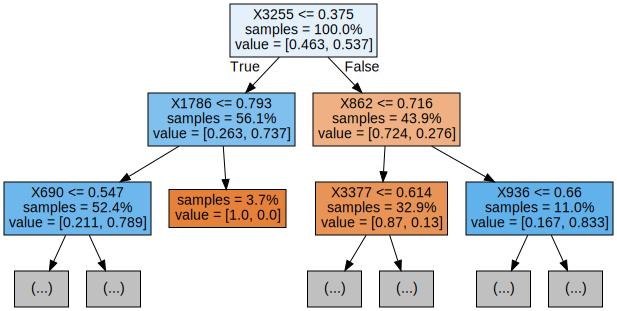

In [17]:
# PROCESSING WITH ALL HYPERPARAMETERS
results_dict_global_rf = {}


for data in dataset_desc: ## for full data set
  if data == 'full_data':
    ### Normalization
    df_norm = normalization_func(df, norm_methods[0]).round(decimals=3)

    ### Run Model --- RandomForestClassifier
    best_rf, x_test,  y_test, x_train, y_train  = get_best_features_random_forest(df_norm)
    print(f'**************** {best_rf} ****************', data)
    results_dict_local = best_random_forest_classifier(best_rf, x_test, y_test, data, x_train, y_train )
    results_dict_global_rf[data] = results_dict_local

  # elif data == 'without_outliers':
  #   for threshold in outlier_thresholds:
  #   ### outlier detection and removal
  #     df_without_outlier = outlier_detection( df, threshold )
  #     ### Normalization
  #     df_norm = normalization_func(df_without_outlier, norm_methods[0]).round(decimals=3)

  #     ### Run Model --- RandomForestClassifier
  #     best_rf, x_test, y_test, x_train, y_train  = get_best_features_random_forest(df_norm)
  #     print(f'**************** {best_rf} ****************', data)
  #     results_dict_local = best_random_forest_classifier(best_rf, x_test, y_test, data + '_' + str(threshold), x_train, y_train )
  #     results_dict_global_rf[ data + '_' + str(threshold)] = results_dict_local

In [18]:
df_norm.shape

(168, 4095)

In [19]:
df_norm[['X3887','y']]['y'].value_counts()

y
4.0    84
3.0    84
Name: count, dtype: int64

In [20]:
df_norm[ df_norm['X3887'] <= 0.419 ]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X4086,X4087,X4088,X4089,X4090,X4091,X4092,X4093,X4094,y
2,0.266,0.422,0.486,0.506,0.539,0.585,0.697,0.730,0.716,0.661,...,0.429,0.371,0.352,0.307,0.219,0.103,0.143,0.135,0.108,4.0
6,0.588,0.615,0.590,0.536,0.489,0.480,0.568,0.585,0.582,0.561,...,0.375,0.336,0.352,0.357,0.364,0.290,0.317,0.299,0.281,4.0
9,0.367,0.443,0.496,0.531,0.483,0.469,0.571,0.583,0.512,0.494,...,0.412,0.301,0.278,0.260,0.200,0.082,0.151,0.164,0.108,4.0
14,0.808,0.818,0.743,0.539,0.251,0.000,0.000,0.000,0.000,0.000,...,0.340,0.295,0.354,0.442,0.525,0.484,0.435,0.337,0.259,4.0
16,0.334,0.401,0.398,0.338,0.288,0.270,0.380,0.422,0.385,0.315,...,0.194,0.209,0.286,0.357,0.397,0.361,0.422,0.390,0.363,3.0
20,0.364,0.422,0.430,0.399,0.375,0.381,0.504,0.538,0.505,0.437,...,0.324,0.332,0.387,0.457,0.517,0.484,0.483,0.451,0.406,3.0
21,0.831,0.865,0.857,0.852,0.811,0.659,0.628,0.557,0.446,0.307,...,0.437,0.418,0.432,0.463,0.494,0.457,0.478,0.494,0.479,4.0
24,0.575,0.586,0.573,0.517,0.452,0.426,0.514,0.545,0.519,0.450,...,0.379,0.367,0.401,0.461,0.528,0.531,0.555,0.534,0.474,3.0
30,0.269,0.365,0.388,0.391,0.381,0.418,0.529,0.548,0.486,0.395,...,0.276,0.238,0.270,0.310,0.308,0.246,0.256,0.214,0.151,3.0
32,0.425,0.487,0.511,0.525,0.536,0.543,0.645,0.709,0.695,0.703,...,0.371,0.324,0.307,0.281,0.194,0.091,0.171,0.207,0.215,4.0


In [21]:
df_norm['y'].value_counts()

y
4.0    84
3.0    84
Name: count, dtype: int64

In [22]:
print((83 / (df_norm.shape[0])) * 100)
print((75 / (df_norm.shape[0])) * 100)

49.404761904761905
44.642857142857146


In [23]:
########### store the results in one dataframe

dict_final_rf = {}
for prefix in sorted(list(set([  key.split('#')[0] for key in results_dict_global_rf.keys() ]))):
  print(prefix)
  # Filter keys based on condition (e.g., keys starting with 'key')
  filtered_keys = [key for key in results_dict_global_rf.keys() if key.startswith(prefix)]
  # Create a list of dictionaries that meet the condition
  filtered_dicts = [ results_dict_global_rf[key] for key in filtered_keys ]
  # # Create DataFrame from the filtered dictionaries
  df_result = pd.DataFrame(filtered_dicts, columns = results_columns_rf)
  # print(df_result, '\n')
  dict_final_rf[prefix] = df_result

full_data


In [24]:
df_final_rf = pd.concat(dict_final_rf.values())

df_final_rf_ = df_final_rf.reset_index().drop('index', axis=1)
df_final_rf_

,dataset,n_estimators,max_depth,accuracy,specificity,sensitivity,roc_auc_score
0,full_data,313,11,0.76,0.79,0.69,0.76
